In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split,cross_val_score,GridSearchCV,RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
import timeit
import seaborn as sns
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score,f1_score,precision_score,recall_score,RocCurveDisplay
from matplotlib import pyplot

In [2]:
x_resampled=pd.read_csv('resampled_without_encoding.csv')
x_resampled_encoding=pd.read_csv('resampled_with_encoding.csv')
y_resampled=pd.read_csv('y_resampled.csv')

## Modelling

### Data with Resampling and without OneHotEncoding

In [3]:
X = x_resampled.values
Y = np.squeeze(y_resampled.values)
X_train,X_test1,y_train,y_test1=train_test_split(X,Y,test_size=0.2,random_state=10)

scaler = StandardScaler().fit(X_train)
train_sc = scaler.transform(X_train)
test_sc = scaler.transform(X_test1)

model=RandomForestClassifier(random_state=48)
start_time = timeit.default_timer()
model.fit(train_sc,y_train)
elapsed = timeit.default_timer() - start_time
y_pred1=model.predict(test_sc)
print("Time taken to fit the model in sec is ",elapsed)
print(f"Accuracy score:{accuracy_score(y_test1, y_pred1):.4f}")
print(f"F1 score : {f1_score(y_test1, y_pred1):.4f}")
print(f"Recall score : {recall_score(y_test1, y_pred1):.4f}")
print(f"Precision score : {precision_score(y_test1, y_pred1):.4f}")

Time taken to fit the model in sec is  382.8573328
Accuracy score:0.9779
F1 score : 0.9776
Recall score : 0.9599
Precision score : 0.9960


<AxesSubplot:>

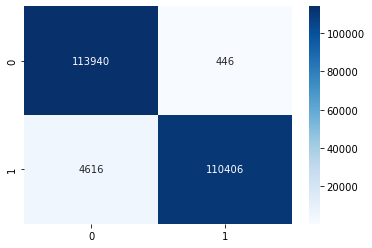

In [4]:
sns.heatmap(confusion_matrix(y_test1,y_pred1),annot=True,fmt='', cmap='Blues')

In [5]:
print(classification_report(y_test1, y_pred1))

              precision    recall  f1-score   support

           0       0.96      1.00      0.98    114386
           1       1.00      0.96      0.98    115022

    accuracy                           0.98    229408
   macro avg       0.98      0.98      0.98    229408
weighted avg       0.98      0.98      0.98    229408



### Feature Selection

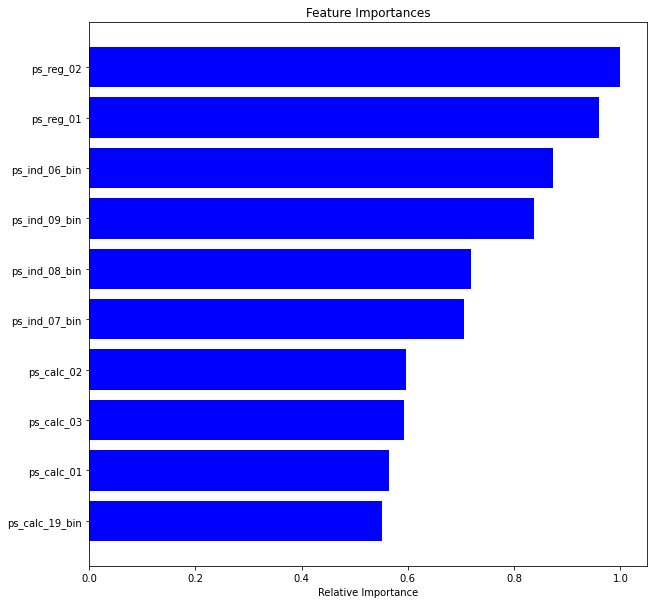

In [6]:
feat_imp = pd.DataFrame({"Col": x_resampled.columns})
feat_imp["Coef"] = model.feature_importances_
feat_imp = feat_imp.sort_values("Coef", ascending=False)
#Scaling Weights
feat_imp["FeatImp"] = (
        (feat_imp["Coef"] - feat_imp["Coef"].min())/ (feat_imp["Coef"].max() - feat_imp["Coef"].min())).round(4)

# customized number 
num_features = 10 
pyplot.figure(figsize=(10,10))
pyplot.title('Feature Importances')
# only plot the customized number of features
pyplot.barh(range(num_features), feat_imp['FeatImp'][:num_features][::-1], color='b', align='center')
pyplot.yticks(range(num_features), feat_imp['Col'][:num_features][::-1])
pyplot.xlabel('Relative Importance')
pyplot.show()

### Data with Resampling and with OneHotEncoding

In [ ]:
X = x_resampled_encoding.values
Y = np.squeeze(y_resampled.values)
X_train,X_test,y_train,y_test=train_test_split(X,Y,test_size=0.2,random_state=10)

scaler = StandardScaler().fit(X_train)
train_sc = scaler.transform(X_train)
test_sc = scaler.transform(X_test)

model=RandomForestClassifier(random_state=48)
start_time = timeit.default_timer()
model.fit(train_sc,y_train)
elapsed = timeit.default_timer() - start_time
y_pred1=model.predict(test_sc)
print("Time taken to fit the model in sec is ",elapsed)
print(f"Accuracy score:{accuracy_score(y_test, y_pred1):.4f}")
print(f"F1 score : {f1_score(y_test, y_pred1):.4f}")
print(f"Recall score : {recall_score(y_test, y_pred1):.4f}")
print(f"Precision score : {precision_score(y_test, y_pred1):.4f}")

In [ ]:
model.get_params()

In [ ]:
RocCurveDisplay.from_predictions(y_test, y_pred1)

In [ ]:
RocCurveDisplay.from_estimator(model,X_test,y_test)

### Feature Selection

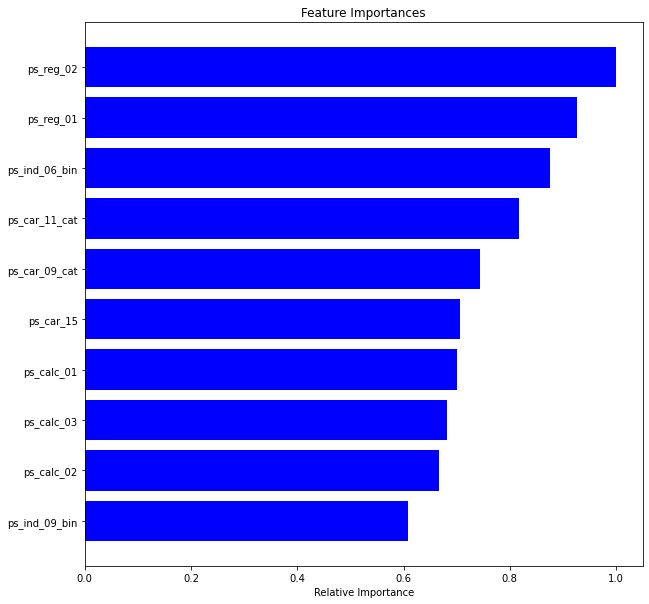

In [17]:
feat_imp = pd.DataFrame({"Col": x_resampled_encoding.columns})
feat_imp["Coef"] = model.feature_importances_
feat_imp["Col"] = feat_imp["Col"].apply(lambda x: (x.split('cat')[0]+'cat') if 'cat' in x else x)
feat_imp = feat_imp.groupby("Col",as_index=False).sum().sort_values("Coef", ascending=False)
feat_imp["FeatImp"] = (
        (feat_imp["Coef"] - feat_imp["Coef"].min())
        / (feat_imp["Coef"].max() - feat_imp["Coef"].min())
    ).round(4)

# customized number 
num_features = 10 
pyplot.figure(figsize=(10,10))
pyplot.title('Feature Importances')
# only plot the customized number of features
pyplot.barh(range(num_features), feat_imp['FeatImp'][:num_features][::-1], color='b', align='center')
pyplot.yticks(range(num_features), feat_imp['Col'][:num_features][::-1])
pyplot.xlabel('Relative Importance')
pyplot.show()

### Cross Validation

In [32]:
rf_reg = RandomForestClassifier(random_state=48)

start_time = timeit.default_timer()
rf_reg.fit(train_sc,y_train)
#perform k fold

cv_r2_scores_rf = cross_val_score(rf_reg, X, Y, cv=5,scoring='r2')
print(cv_r2_scores_rf)
print("Mean 5-Fold R Squared: {}".format(np.mean(cv_r2_scores_rf)))

elapsed = timeit.default_timer() - start_time
print(elapsed)

[0.61727577 0.98066319 0.97996574 0.98088986 0.98001805]
Mean 5-Fold R Squared: 0.9077625205193278
2639.3376154


* We see that the metrics for all folds in cross_val_score are uniform so it can be concluded that the model is able to generalise
* As 4 subsets gave accuracy of 98 we can conside the above model result is not overfitting

#### There is same accuracy with and without OneHotEncoding

### Hyperparameter tuning

* Hyperparameter tuning can be advantageous in creating a model that is better at classification. 
* In the case of a random forest, it may not be necessary, as random forests are already very good at classification. 
* Using exhaustive grid search to choose hyperparameter values can be very time consuming as well.
* However, in cases where there are only a few potential values for your hyperparameters or when your initial classification model isn’t very accurate, it might be a good idea to at least investigate the effect of changing some of the hyperparameter values in your model.

### As there is high accuracy it may not necessary to do hyperparameter tuning

https://towardsdatascience.com/optimizing-hyperparameters-in-random-forest-classification-ec7741f9d3f6#:~:text=Hyperparameter%20tuning%20can%20be%20advantageous%20in%20creating%20a,values%20can%20be%20very%20time%20consuming%20as%20well.